In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_dataset("Kanakmi/mental-disorders")
num_labels = len(set(dataset["train"]["label"]))

# Tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# Preprocess
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Dataloaders
train_loader = DataLoader(dataset["train"], batch_size=16, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=16)

# Optimizer and loss
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Training loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

print("Training complete.")


README.md:   0%|          | 0.00/120 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/465051 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23190 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/92976 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2025-04-22 14:40:46.989405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745332847.173423      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745332847.224793      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/465051 [00:00<?, ? examples/s]

Map:   0%|          | 0/23190 [00:00<?, ? examples/s]

Map:   0%|          | 0/92976 [00:00<?, ? examples/s]

Epoch 3: 100%|██████████| 29066/29066 [3:29:56<00:00,  2.31it/s, loss=0.535]

Training complete.


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store raw text if you want CSV output
        batch_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        all_texts.extend(batch_texts)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Evaluating: 100%|██████████| 1450/1450 [02:44<00:00,  8.83it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      8472
           1       0.70      0.69      0.69      1405
           2       0.74      0.77      0.76      4877
           3       0.88      0.83      0.85      6440
           4       0.65      0.58      0.61       467
           5       0.55      0.35      0.42      1529

    accuracy                           0.79     23190
   macro avg       0.72      0.68      0.70     23190
weighted avg       0.79      0.79      0.79     23190


Confusion Matrix:
[[7508  146  472  216   20  110]
 [ 209  963   97   71   39   26]
 [ 628   63 3777  264    5  140]
 [ 471   65  383 5370   20  131]
 [  49   59   28   35  272   24]
 [ 325   87  344  180   65  528]]


<Axes: >

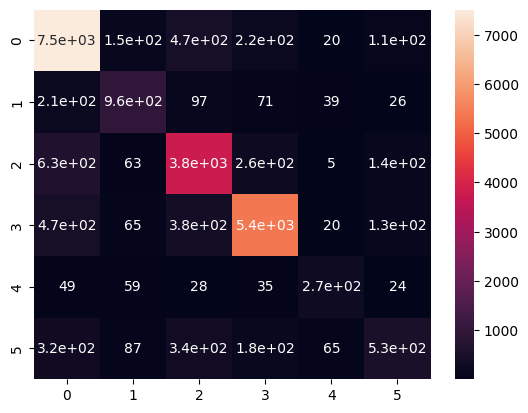

In [3]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True)